# Contour misalignment

In [3]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import dask.array as dsa
from cosima_cookbook import distributed as ccd
import cartopy.crs as ccrs
import cmocean as cm
from scipy.ndimage.filters import uniform_filter1d
import matplotlib as mpl
from collections import OrderedDict

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:35191 Dashboard: /proxy/33429/status,Cluster Workers: 4 Cores: 16 Memory: 64.00 GiB


In [5]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [6]:
# This example script just calculates transports for a single year. 
# You'll need to run it multiple times (or set up loop over years)

year = '2170'
expt = '01deg_jra55v13_ryf9091'

start_time= year + '-01-01'
end_time= year + '-12-31'

# reference density value:
rho_0 = 1035.0
# Note: change this range, so it matches the size of your contour arrays:

## FULL SO ##
lat_range = slice(-70,-34.99)
lat_range_big =  slice(-70.05,-34.90)
#-0.1,2,3,4,5#
lat_range = slice(-60,-34.99)
lat_range_big = slice(-60.05,-34.90)
#-0.6,7#
lat_range = slice(-60,-39.98)
lat_range_big = slice(-60.05,-39.90)
#-0.8,-0.9,-1.0#
lat_range = slice(-62.91,-45)
lat_range_big = slice(-62.96,-44.90)
#-1.1,1.2#
lat_range = slice(-64.99,-47)
lat_range_big = slice(-65.02,-46.93)
#-1.3,1.4,-1.5#
lat_range = slice(-70,-47)
lat_range_big = slice(-70.05,-46.93)
# Select contour depth



In [7]:
hotspot_dict = OrderedDict([
    ('PAR',  {'lon_slice':slice(-160,-130),'lat_slice':slice(-60,-50),'x1':-160,'x2':-130,'y1':-60,'y2':-50}),
    ('KP',  {'lon_slice':slice(-280,-250),'lat_slice':slice(-60,-40),'x1':-280,'x2':-250,'y1':-60,'y2':-40}),
    ('SWIR',  {'lon_slice':slice(10,50),'lat_slice':slice(-55,-45),'x1':10,'x2':50,'y1':-55,'y2':-45}),
    ('DP',  {'lon_slice':slice(-70,-30),'lat_slice':slice(-60,-40),'x1':-70,'x2':-30,'y1':-60,'y2':-40}),
    ('MR',  {'lon_slice':slice(-210,-170),'lat_slice':slice(-60,-45),'x1':-210,'x2':-170,'y1':-60,'y2':-45}),

])

In [8]:
contour_dict = OrderedDict([
    ('A',  {'SSH':-0.1,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.1m_SSH.npz','shifted':False}),
    ('B',  {'SSH':-0.2,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.2m_SSH.npz','shifted':False}),
    ('C',  {'SSH':-0.3,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.3m_SSH.npz','shifted':False}),
    ('D',  {'SSH':-0.4,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.4m_SSH.npz','shifted':False}),
    ('E',  {'SSH':-0.5,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.5m_SSH.npz','shifted':False}),
    ('F',  {'SSH':-0.6, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.6m_SSH.npz','shifted':False}),
    ('G',  {'SSH':-0.7, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.7m_SSH.npz','shifted':False}),
    ('H',  {'SSH':-0.8, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.8m_SSH.npz','shifted':False}),
    ('I',  {'SSH':-0.9, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.9m_SSH.npz','shifted':False}),
    ('J',  {'SSH':-1.0, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-1.0m_SSH.npz','shifted':False}),
    ('K',  {'SSH':-1.1, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.1m_SSH.npz','shifted':False}),
    ('L',  {'SSH':-1.2, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.2m_SSH.npz','shifted':False}),
    ('M',  {'SSH':-1.3, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.3m_SSH.npz','shifted':False}),
    ('N',  {'SSH':-1.4, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.4m_SSH.npz','shifted':False}),
    ('O',  {'SSH':-1.5, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.5m_SSH.npz','shifted':True}),
    ('P',  {'SSH':-0.15,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.15m_SSH.npz','shifted':False}),
    ('Q',  {'SSH':-0.25,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.25m_SSH.npz','shifted':False}),
    ('R',  {'SSH':-0.35,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.35m_SSH.npz','shifted':False}),
    ('S',  {'SSH':-0.45,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.45m_SSH.npz','shifted':False}),
    ('T',  {'SSH':-0.55,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.55m_SSH.npz','shifted':False}),
    ('U',  {'SSH':-0.65, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.65m_SSH.npz','shifted':False}),
    ('V',  {'SSH':-0.75, 'lat_range':slice(-61,-39.98),'lat_range_big':slice(-61.05,-39.90),'slope_path':'SO_slope_contour_-0.75m_SSH.npz','shifted':False}),
    ('W',  {'SSH':-0.85,'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.85m_SSH.npz','shifted':False}),
    ('X',  {'SSH':-0.95, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.95m_SSH.npz','shifted':False}),
    ('Y',  {'SSH':-1.05, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-1.05m_SSH.npz','shifted':False}),
    ('Z',  {'SSH':-1.15, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.15m_SSH.npz','shifted':False}),
    ('Z1',  {'SSH':-1.25, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.25m_SSH.npz','shifted':False}),
    ('Z2',  {'SSH':-1.35, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.35m_SSH.npz','shifted':False}),
    ('Z3',  {'SSH':-1.45, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.45m_SSH.npz','shifted':True}),
    ('Z4',  {'SSH':-1.55, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.55m_SSH_A.npz','shifted':True}),
    ('Z5',  {'SSH':-1.55, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.55m_SSH_B.npz','shifted':True}),
    ('Z6',  {'SSH':-1.6, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.6m_SSH_A.npz','shifted':True}),
    ('Z7',  {'SSH':-1.6, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.6m_SSH_B.npz','shifted':True}),
    ('Z8',  {'SSH':-1.65, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.65m_SSH_A.npz','shifted':True}),
    ('Z9',  {'SSH':-1.65, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.65m_SSH_B.npz','shifted':True}),
])

In [9]:
uh_bar = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/uh_bar_10yr.nc').uh_bar
vh_bar = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/vh_bar_10yr.nc').vh_bar
h_bar = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/h_bar_10yr.nc').h_bar
u_hat = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/u_hat_10yr.nc').u_hat
v_hat = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/v_hat_10yr.nc').v_hat

In [15]:
def misalignment(j_contour, rhoslice):
    SSH = contour_dict[j_contour]['SSH']
    if contour_dict[j_contour]['shifted']==True:
        suffix = '_shiftedback'
        segment_length = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'segment_length'+suffix+'.nc').segment_length

    else:
        suffix = ''
        segment_length = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_segment_length'+suffix+'.nc').segment_length

    lat_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon'+suffix+'.nc').lat_along_contour
    lon_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon'+suffix+'.nc').lon_along_contour
    uh = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_mean_velocities_along_contours'+suffix+'.nc').uh_bar_contour
    vh = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_mean_velocities_along_contours'+suffix+'.nc').vh_bar_contour
    uh = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_mean_velocities_along_contours'+suffix+'.nc').u_hat_contour
    vh = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_mean_velocities_along_contours'+suffix+'.nc').v_hat_contour
    uh_rhoslice = uh.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins')
    vh_rhoslice = vh.sel(isopycnal_bins = rhoslice).sum('isopycnal_bins')
    abs_uv = np.sqrt(uh_rhoslice**2+vh_rhoslice**2)
    N = 2
    smooth_lon = uniform_filter1d(lon_along_contour, size=N)
    smooth_lat = uniform_filter1d(lat_along_contour, size=N)
    
    smooth_lat_i = np.roll(smooth_lat,-1)
    smooth_lon_i = np.roll(smooth_lon,-1)
    
    Dy = smooth_lat_i-smooth_lat
    Dx = smooth_lon_i-smooth_lon
    
    abs_DyDx = np.sqrt(Dy**2+Dx**2)
    
    dotproduct = (uh_rhoslice*Dx+vh_rhoslice*Dy)/abs_DyDx/abs_uv
    return dotproduct, lat_along_contour, lon_along_contour
    

In [13]:
def plot_contour_dot(rhoslice, hotspot, ax):
    lat_slice = hotspot_dict[hotspot]['lat_slice']
    lon_slice = hotspot_dict[hotspot]['lon_slice']
    isopycnal_bins_sigma1 = 1000+ np.array([1,28,29,30,31,31.5,31.9,32,32.1,32.2,32.25,32.3,
                                        32.35,32.4,32.42,32.44,32.46,32.48,32.50,32.51,
                                        32.52,32.53,32.54,32.55,32.56,32.58,32.6,32.8,33,34,45])
    for j in np.array([0,2,4,6,8,10,12,14,16,18,19,20,21,22,24,26,28,30,32,34]):
        j_contour = np.array(['A','P','B','Q','C','R','D','S','E','T','F','U','G','V','H','W','I','X','J','Y',
                              'K','Z','L','Z1','M','Z2','N','Z3','O','Z4','Z5','Z6','Z7','Z8','Z9'])[j]
        dot, lat_along_contour, lon_along_contour = misalignment(j_contour, rhoslice)        
        SSH = contour_dict[j_contour]['SSH']
        newcmap = cm.tools.crop_by_percent(cm.cm.gray, 10, which='max', N= None)
        sc = ax.scatter(lon_along_contour,lat_along_contour, s=0.5, label = 'SSH '+str(SSH)+' m', c = dot , cmap = newcmap, vmax = 1, vmin = -1)

    #plt.legend(loc = 'upper right')
    #cbar = fig.colorbar(sc, ax = ax)
    #cbar.set_label('Dot', rotation=90)
    ax.set_ylim(hotspot_dict[hotspot]['y1'],hotspot_dict[hotspot]['y2'])
    ax.set_xlim(hotspot_dict[hotspot]['x1'],hotspot_dict[hotspot]['x2'])
    ax.set_xlabel('Longitude ($^\circ$E)')
    ax.set_ylabel('Latitude ($^\circ$N)')

In [14]:
def plot_contour_dot_right(rhoslice, hotspot, ax):
    lat_slice = hotspot_dict[hotspot]['lat_slice']
    lon_slice = hotspot_dict[hotspot]['lon_slice']
    isopycnal_bins_sigma1 = 1000+ np.array([1,28,29,30,31,31.5,31.9,32,32.1,32.2,32.25,32.3,
                                        32.35,32.4,32.42,32.44,32.46,32.48,32.50,32.51,
                                        32.52,32.53,32.54,32.55,32.56,32.58,32.6,32.8,33,34,45])
    for j in np.array([0,2,4,6,8,10,12,14,16,18,19,20,21,22,24,26,28,30,32,34]):
        j_contour = np.array(['A','P','B','Q','C','R','D','S','E','T','F','U','G','V','H','W','I','X','J','Y',
                              'K','Z','L','Z1','M','Z2','N','Z3','O','Z4','Z5','Z6','Z7','Z8','Z9'])[j]
        dot, lat_along_contour, lon_along_contour = misalignment(j_contour, rhoslice)        
        SSH = contour_dict[j_contour]['SSH']
        newcmap = cm.tools.crop_by_percent(cm.cm.gray, 10, which='max', N= None)
        sc = ax.scatter(lon_along_contour,lat_along_contour, s=0.5, label = 'SSH '+str(SSH)+' m', c = dot , cmap = newcmap, vmax = 1, vmin = -1)
    #plt.legend(loc = 'upper right')
    #cbar = fig.colorbar(sc, ax = ax)
    #cbar.set_label('Dot', rotation=90)
    ax.set_ylim(hotspot_dict[hotspot]['y1'],hotspot_dict[hotspot]['y2'])
    ax.set_xlim(hotspot_dict[hotspot]['x1'],hotspot_dict[hotspot]['x2'])
    ax.set_xlabel('Longitude ($^\circ$E)')
    #ax.set_ylabel('Latitude ($^\circ$N)')
    return sc

In [10]:
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 13})


In [11]:
rho_0 = 1035

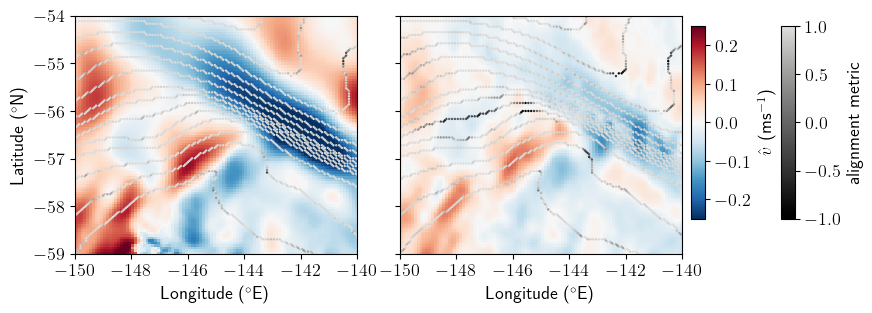

In [16]:
fig,axes = plt.subplots(nrows = 1, ncols =2,figsize = (9,3.5), sharey= True)

(vh_bar.sel(isopycnal_bins = slice(1001,1031.5)).sum('isopycnal_bins')/h_bar.sel(isopycnal_bins = slice(1001,1031.5)).sum('isopycnal_bins')/rho_0).plot(ax = axes[0], vmax = 0.25, vmin = -0.25, cmap = 'RdBu_r', add_colorbar = False)
plot_contour_dot(slice(1001,1031.5),'PAR',axes[0])
axes[0].set_xlim(-150,-140)
axes[0].set_ylim(-59,-54)

p1 = (vh_bar.sel(isopycnal_bins = slice(1032.22305317,1032.5)).sum('isopycnal_bins')/h_bar.sel(isopycnal_bins = slice(1032.22305317,1032.5)).sum('isopycnal_bins')/rho_0).plot(ax = axes[1], vmax = 0.25, vmin = -0.25, cmap = 'RdBu_r', add_colorbar = False)
sc = plot_contour_dot_right(slice(1032.22305317,1032.5),'PAR',axes[1])
axes[1].set_xlim(-150,-140)
axes[1].set_ylim(-59,-54)
axes[1].set_ylabel('')

fig.subplots_adjust(right = 0.8,bottom = 0.2,wspace = 0.15)

ax_cb = plt.axes([0.81, 0.3, 0.015, 0.55])
cb = plt.colorbar(p1,cax=ax_cb, orientation='vertical')
cb.ax.set_ylabel('$\hat{v}$ (ms$^{-1}$)');
ax_cb = plt.axes([0.91, 0.3, 0.015, 0.55])
cb = plt.colorbar(sc,cax=ax_cb, orientation='vertical')
cb.ax.set_ylabel('alignment metric');

#fig.savefig('contour_alignment.png',dpi = 400)